In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  2 01:59:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Background:

- We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

- We are interested in developing a robust machine learning system that leverages information coming from call center data.

- Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

##Data Description:

- The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

##Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

####y - has the client subscribed to a term deposit? (binary)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

import numpy as np

from pandas.core.common import random_state
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier as rbf
from sklearn.pipeline import Pipeline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
data = pd.read_csv('drive/MyDrive/Colab Notebooks/apziva/term-deposit-marketing-2020_onehot.csv')
data.drop(columns=['Unnamed: 0'],inplace = True)
data

,age,education,default,balance,housing,loan,duration,campaign,job_admin,job_blue-collar,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,y
0,58,1,0,2143,1,0,261,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,2,0,29,1,0,151,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,33,2,0,2,1,1,76,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,4,0,1506,1,0,92,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,33,4,0,1,0,0,198,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,1,0,395,0,0,107,1,0,0,...,0,0,0,1,0,0,0,1,0,0
39996,30,1,0,3340,0,0,238,3,0,0,...,0,0,0,0,0,0,0,0,1,1
39997,54,2,0,200,0,0,170,1,1,0,...,0,0,0,0,0,0,1,0,0,1
39998,34,1,0,1047,0,0,342,1,0,0,...,0,0,0,0,0,0,0,1,0,0


# There is a huge Class imbalance problem,
attempt to deal with that: 
using the Python library imbalanced-learn.

In [5]:
from imblearn.combine import SMOTETomek 
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks 

In [6]:
smo = SMOTE(random_state = 123)
tom = TomekLinks( n_jobs= -1)

ST = SMOTETomek(smote= smo,tomek=tom,random_state=123)#,sampling_strategy= 0.818)

In [7]:
X = data.iloc[:,:-1]
X
y = data['y']
y

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64

In [8]:
X_res, y_res = ST.fit_resample(X, y)

In [9]:
X_res

,age,education,default,balance,housing,loan,duration,campaign,job_admin,job_blue-collar,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,1,0,2143,1,0,261,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,44,2,0,29,1,0,151,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,33,2,0,2,1,1,76,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,47,4,0,1506,1,0,92,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,33,4,0,1,0,0,198,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72984,39,2,0,0,0,0,166,1,0,0,...,0,0,0,0,0,0,0,0,0,0
72985,56,2,0,516,0,0,262,1,0,0,...,0,0,0,0,0,0,0,0,0,0
72986,28,2,0,63,0,0,227,1,0,0,...,0,0,0,0,0,0,0,0,0,0
72987,28,2,0,675,1,0,565,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
y_res

0        0
1        0
2        0
3        0
4        0
        ..
72984    1
72985    1
72986    1
72987    1
72988    1
Name: y, Length: 72989, dtype: int64

In [11]:
X_res['y'] = y_res
data_res = X_res
data_res

,age,education,default,balance,housing,loan,duration,campaign,job_admin,job_blue-collar,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,y
0,58,1,0,2143,1,0,261,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,2,0,29,1,0,151,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,33,2,0,2,1,1,76,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,4,0,1506,1,0,92,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,33,4,0,1,0,0,198,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72984,39,2,0,0,0,0,166,1,0,0,...,0,0,0,0,0,0,0,0,0,1
72985,56,2,0,516,0,0,262,1,0,0,...,0,0,0,0,0,0,0,0,0,1
72986,28,2,0,63,0,0,227,1,0,0,...,0,0,0,0,0,0,0,0,0,1
72987,28,2,0,675,1,0,565,2,0,0,...,0,0,0,0,0,0,0,0,0,1


# Now the machine learning models being fit

In [12]:
X =data_res.iloc[:,:-1].values
y = data_res.y.values


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score ,  accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

logistic = LogisticRegression(penalty='l2', C=0.1) # instantiate the model
# try l1 penalty(like ridge)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)


In [ ]:
# fit the initial model
logistic.fit(X = X_train,y = y_train)
y_pred = logistic.predict(X= X_test)
y_score = logistic.predict_proba(X_test)[:, 1]

In [ ]:
print(confusion_matrix(y_pred, y_test))
print(roc_auc_score(y_test,y_score))
print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
# the initial confusion matrix

[[7346  445]
 [  79  130]]
0.8910491582491583
0.9345
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      7425
           1       0.62      0.23      0.33       575

    accuracy                           0.93      8000
   macro avg       0.78      0.61      0.65      8000
weighted avg       0.92      0.93      0.92      8000



In [ ]:
# now a grid serch for logistic
C_range = []
import numpy as np
C_range = np.linspace(0.01, 0.1,11).round(2).tolist()

for i in np.linspace(0.2, 1.1,11).round(1).tolist():
  C_range.append(i)

for i in range(10,101,10):
  C_range.append(i)

l1_range = []
l1_range = np.linspace(0.1, 0.9,9).round(1).tolist()
l1_range

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
from sklearn.pipeline import Pipeline

logistic = LogisticRegression(solver= 'saga',class_weight= 'balanced',max_iter = 10000)
scaler = StandardScaler()



pipeline = Pipeline(steps = [('scaler', scaler), ('estimator', logistic)])
parameters = [{'estimator__penalty': ['l1', 'l2'], "estimator__C": C_range},
              {'estimator__penalty' :['none']},
              {'estimator__penalty': ['elasticnet'], 'estimator__l1_ratio':l1_range, 'estimator__C': C_range}
              ]



clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=5)
clf.fit(X = X, y=y) 



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           solver='saga'))]),
             param_grid=[{'estimator__C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.06, 0.07, 0.08, 0.09, 0.1, 0.2,
                                           0.3, 0.4, 0.5, 0.6, 0.7, 0.7, 0.8,
                                           0.9, 1.0, 1.1, 10, 20, 30, 40, 50,
                                           60, 70, 80, ...],
                          'estimator__penalty': ['l1', 'l2']},
                         {'estimator__penalty': ['none']},
                         {'estimator__C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                           0.06,

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
select_results = pd.DataFrame(clf.cv_results_)[['param_estimator__penalty','param_estimator__C','param_estimator__l1_ratio','mean_test_score','rank_test_score']]
select_results.sort_values('mean_test_score', ascending=False)

,param_estimator__penalty,param_estimator__C,param_estimator__l1_ratio,mean_test_score,rank_test_score
0,l1,0.01,NaN,0.882032,1
73,elasticnet,0.01,0.9,0.882000,2
72,elasticnet,0.01,0.8,0.881973,3
71,elasticnet,0.01,0.7,0.881933,4
70,elasticnet,0.01,0.6,0.881885,5
...,...,...,...,...,...
48,l1,30,NaN,0.881425,349
317,elasticnet,70,0.1,0.881425,350
295,elasticnet,40,0.6,0.881425,351
58,l1,80,NaN,0.881424,352


# model validation using pre-resampled data

In [ ]:
# model validation using pre-resampled data
class_0 = data.loc[data.y == 0].sample(n=5000, random_state=123)
class_1 = data.loc[data.y == 1].sample(n=500, random_state=123)
data_val = pd.concat([class_0,class_1], ignore_index= True).sample(frac=1)
data_val

scaler = StandardScaler()
X_test = data_val.iloc[:,:-1].values
X_test = scaler.fit_transform(X_test)
y_test = data_val.y.values

# the scores and classification report matrix using the best found model(trained on post-SMOTETomek data, tested on original data with original class ratio)

In [ ]:
logistic = LogisticRegression(solver = 'saga',penalty='l1', C=0.01)
scaler = StandardScaler()
X_train =scaler.fit_transform(X)
logistic.fit(X = X_train,y = y)


y_pred = logistic.predict(X= X_test)
y_score = logistic.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_pred, y_test))
print(roc_auc_score(y_test,y_score))
print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


[[4954  401]
 [  46   99]]
0.8946328000000001
0.9187272727272727
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5000
           1       0.68      0.20      0.31       500

    accuracy                           0.92      5500
   macro avg       0.80      0.59      0.63      5500
weighted avg       0.90      0.92      0.90      5500



# Now use XGB boosting machine
https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
## the  scale_pos_weight parameter allows for effective class imbalance adjustment

XGBoost is trained to minimize a loss function and the “gradient” in gradient boosting refers to the steepness of this loss function, e.g. the amount of error. A small gradient means a small error and, in turn, a small change to the model to correct the error. A large error gradient during training in turn results in a large correction.

Small Gradient: Small error or correction to the model. 

Large Gradient: Large error or correction to the model.

Gradients are used as the basis for fitting subsequent trees added to boost or correct errors made by the existing state of the ensemble of decision trees.

###The scale_pos_weight value is used to scale the gradient for the positive class.

In [ ]:
# the pre-resampled data
data
y

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64

In [ ]:
from xgboost import XGBClassifier
weights = [1, 10,13, 25, 50, 75, 100, 1000]
n_range = [100,500,1000,5000]
lear_rate = [0.001,0.005,0.01,0.05,0.1,0.5,0.8,1]

from sklearn.pipeline import Pipeline

XGB = XGBClassifier(random_state = 123, tree_method = 'gpu_hist',sampling_method = 'gradient_based')
#scaler = StandardScaler()



pipeline = Pipeline(steps = [ ('estimator', XGB)])
parameters = [{'estimator__scale_pos_weight': weights, "estimator__n_estimators": n_range},

              ]



clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=5)
clf.fit(X = X.values, y=y.values) 



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estimator',
                                        XGBClassifier(random_state=123,
                                                      sampling_method='gradient_based',
                                                      tree_method='gpu_hist'))]),
             param_grid=[{'estimator__n_estimators': [100, 500, 1000, 5000],
                          'estimator__scale_pos_weight': [1, 10, 13, 25, 50, 75,
                                                          100, 1000]}],
             scoring='roc_auc')

In [ ]:
select_results = pd.DataFrame(clf.cv_results_)[['param_estimator__scale_pos_weight','param_estimator__n_estimators','mean_test_score','rank_test_score']]
select_results.sort_values('mean_test_score', ascending=False)

,param_estimator__scale_pos_weight,param_estimator__n_estimators,mean_test_score,rank_test_score
1,10,100,0.890808,1
2,13,100,0.890583,2
5,75,100,0.890213,3
3,25,100,0.890156,4
4,50,100,0.889921,5
6,100,100,0.889736,6
0,1,100,0.889635,7
7,1000,100,0.889152,8
8,1,500,0.886529,9
9,10,500,0.884656,10


In [ ]:
from xgboost import XGBClassifier
weights = [1, 10,13, 25, 50, 75, 100, 1000]
n_range = [100,500,1000,5000]
tree_op = ['grow_local_histmaker','approx']
sample_med = ['gradient_based',]

from sklearn.pipeline import Pipeline

XGB = XGBClassifier(random_state = 123, tree_method = 'gpu_hist',sampling_method = 'gradient_based')
#scaler = StandardScaler()



pipeline = Pipeline(steps = [ ('estimator', XGB)])
parameters = [{'estimator__tree_method':tree_op,'estimator__scale_pos_weight': weights, "estimator__n_estimators": n_range},
              {'estimator__tree_method': ['gpu_hist'],'estimator__sampling_method': ['gradient_based'],'estimator__scale_pos_weight': weights, "estimator__n_estimators": n_range},

              ]



clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=5)
clf.fit(X = X.values, y=y.values) 



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/tra

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estimator',
                                        XGBClassifier(random_state=123,
                                                      sampling_method='gradient_based',
                                                      tree_method='gpu_hist'))]),
             param_grid=[{'estimator__n_estimators': [100, 500, 1000, 5000],
                          'estimator__scale_pos_weight': [1, 10, 13, 25, 50, 75,
                                                          100, 1000],
                          'estimator__tree_method': ['grow_local_histmaker',
                                                     'approx']},
                         {'estimator__n_estimators': [100, 500, 1000, 5000],
                          'estimator__sampling_method': ['gradient_based'],
                          'estimator__scale_pos_weight': [1, 10, 13, 25, 50, 75,
                                                          100, 1000],
            

In [ ]:
select_results = pd.DataFrame(clf.cv_results_)[['param_estimator__scale_pos_weight','param_estimator__n_estimators','param_estimator__tree_method','mean_test_score','rank_test_score']]
select_results.sort_values('mean_test_score', ascending=False)

,param_estimator__scale_pos_weight,param_estimator__n_estimators,param_estimator__tree_method,mean_test_score,rank_test_score
11,75,100,approx,0.890841,1
65,10,100,gpu_hist,0.890808,2
3,10,100,approx,0.890778,3
5,13,100,approx,0.890706,4
7,25,100,approx,0.890631,5
...,...,...,...,...,...
54,25,5000,grow_local_histmaker,NaN,92
56,50,5000,grow_local_histmaker,NaN,93
58,75,5000,grow_local_histmaker,NaN,94
60,100,5000,grow_local_histmaker,NaN,65


In [ ]:
from xgboost import XGBClassifier
weights = [1, 10,13, 25, 50, 75, 100, 1000]
n_range = [100,500,1000,5000]
learn_rate = [0.001,0.005,0.01,0.05,0.1,0.5,0.8,1]

from sklearn.pipeline import Pipeline

XGB = XGBClassifier(random_state = 123, tree_method = 'gpu_hist',sampling_method = 'gradient_based')
#scaler = StandardScaler()



pipeline = Pipeline(steps = [ ('estimator', XGB)])
parameters = [{'estimator__scale_pos_weight': weights, "estimator__n_estimators": n_range,"estimator__learning_rate": learn_rate},

              ]



clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=5)
clf.fit(X = X.values, y=y.values) 



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estimator',
                                        XGBClassifier(random_state=123,
                                                      sampling_method='gradient_based',
                                                      tree_method='gpu_hist'))]),
             param_grid=[{'estimator__learning_rate': [0.001, 0.005, 0.01, 0.05,
                                                       0.1, 0.5, 0.8, 1],
                          'estimator__n_estimators': [100, 500, 1000, 5000],
                          'estimator__scale_pos_weight': [1, 10, 13, 25, 50, 75,
                                                          100, 1000]}],
             scoring='roc_auc')

In [ ]:
select_results = pd.DataFrame(clf.cv_results_)[['param_estimator__scale_pos_weight','param_estimator__n_estimators',"param_estimator__learning_rate",'mean_test_score','rank_test_score']]
select_results.sort_values('mean_test_score', ascending=False)

,param_estimator__scale_pos_weight,param_estimator__n_estimators,param_estimator__learning_rate,mean_test_score,rank_test_score
129,10,100,0.1,0.890808,1
81,10,1000,0.01,0.890650,2
130,13,100,0.1,0.890583,3
82,13,1000,0.01,0.890547,4
83,25,1000,0.01,0.890449,5
...,...,...,...,...,...
253,75,5000,1,0.819105,252
223,1000,5000,0.8,0.819010,253
239,1000,500,1,0.777882,254
247,1000,1000,1,0.772113,255


In [ ]:
# ALSO TRY TUNING MAX DEPTH


# propertyfeature_importances_: numpy.ndarray
# Feature importances property, return depends on importance_type parameter.

# Returns
# feature_importances_ (array of shape [n_features] except for multi-class)

# linear model, which returns an array with shape (n_features, n_classes)



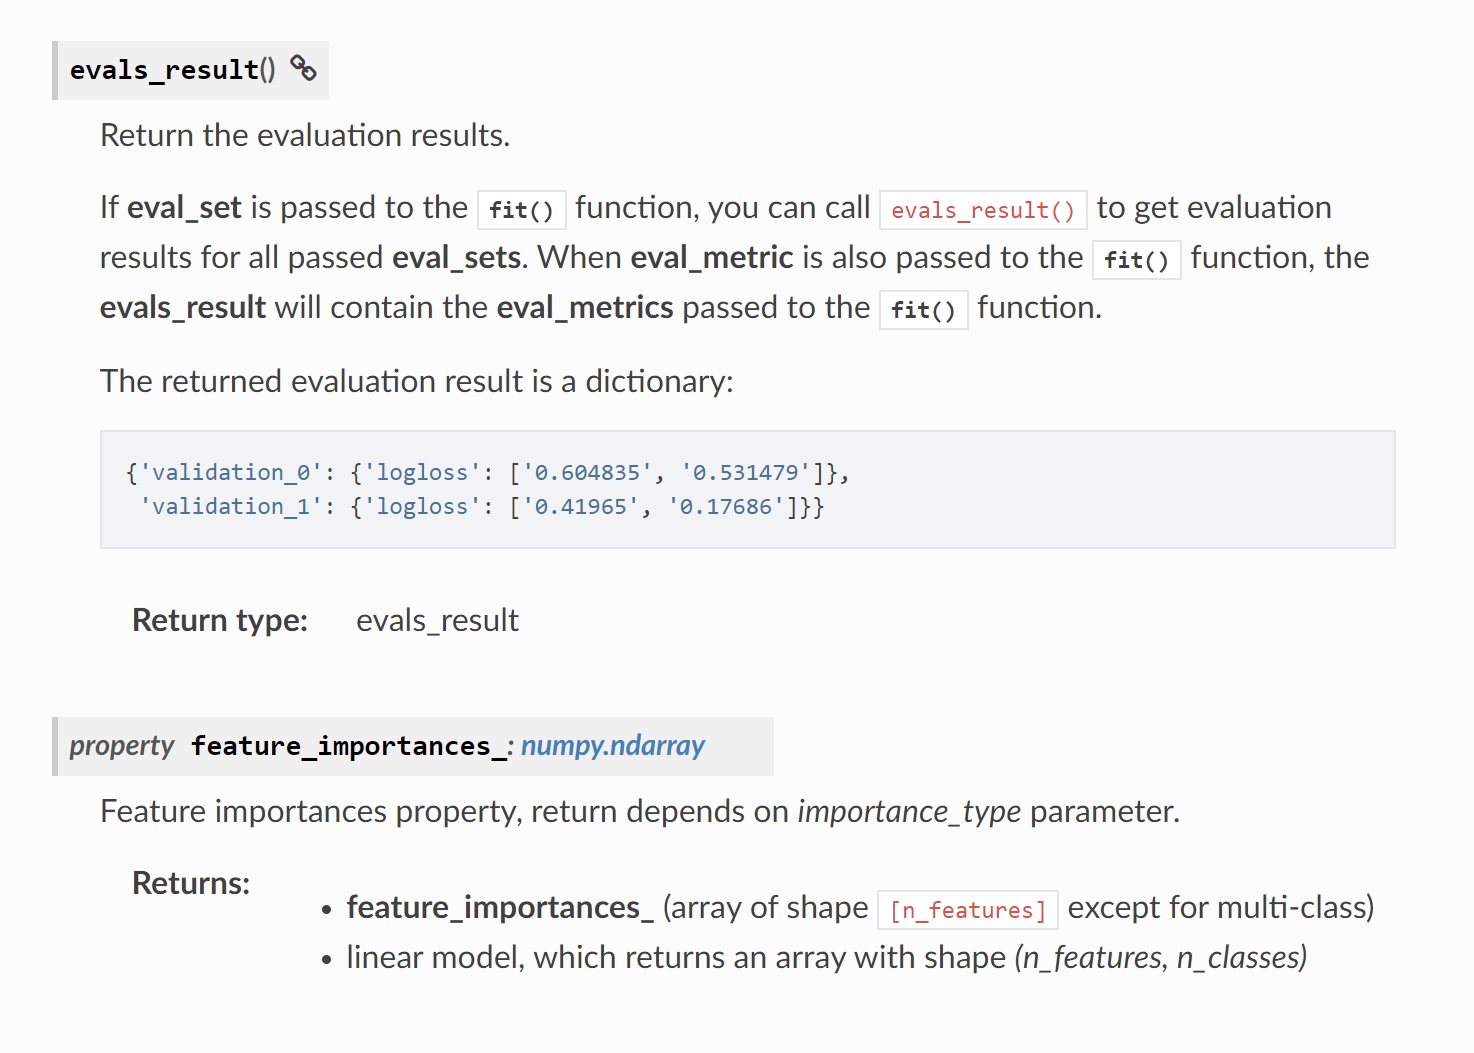

array([0, 0, 0, ..., 1, 1, 1])

# Bounus 2: What makes the customers buy? Tell us which feature we should be focusing more on.
# feature importance analysis

In [17]:
from xgboost import XGBClassifier

model = XGBClassifier(scale_pos_weight =10,n_estimators = 100, learning_rate = 0.1)
model.fit(X = X, y=y) 

XGBClassifier(scale_pos_weight=10)

In [21]:
print(model.evals_result)

<bound method XGBClassifier.evals_result of XGBClassifier(scale_pos_weight=10)>


In [19]:
import seaborn as sas
model.feature_importances_

array([0.00745327, 0.03967571, 0.        , 0.00623752, 0.14210525,
       0.07222227, 0.08624679, 0.04046353, 0.0324278 , 0.05079487,
       0.03226917, 0.02338018, 0.05245031, 0.01904951, 0.03092525,
       0.04296997, 0.01236967, 0.05278922, 0.02799198, 0.01365601,
       0.10018147, 0.04971854, 0.06462178], dtype=float32)

In [32]:
column_names = data.columns[:-1]

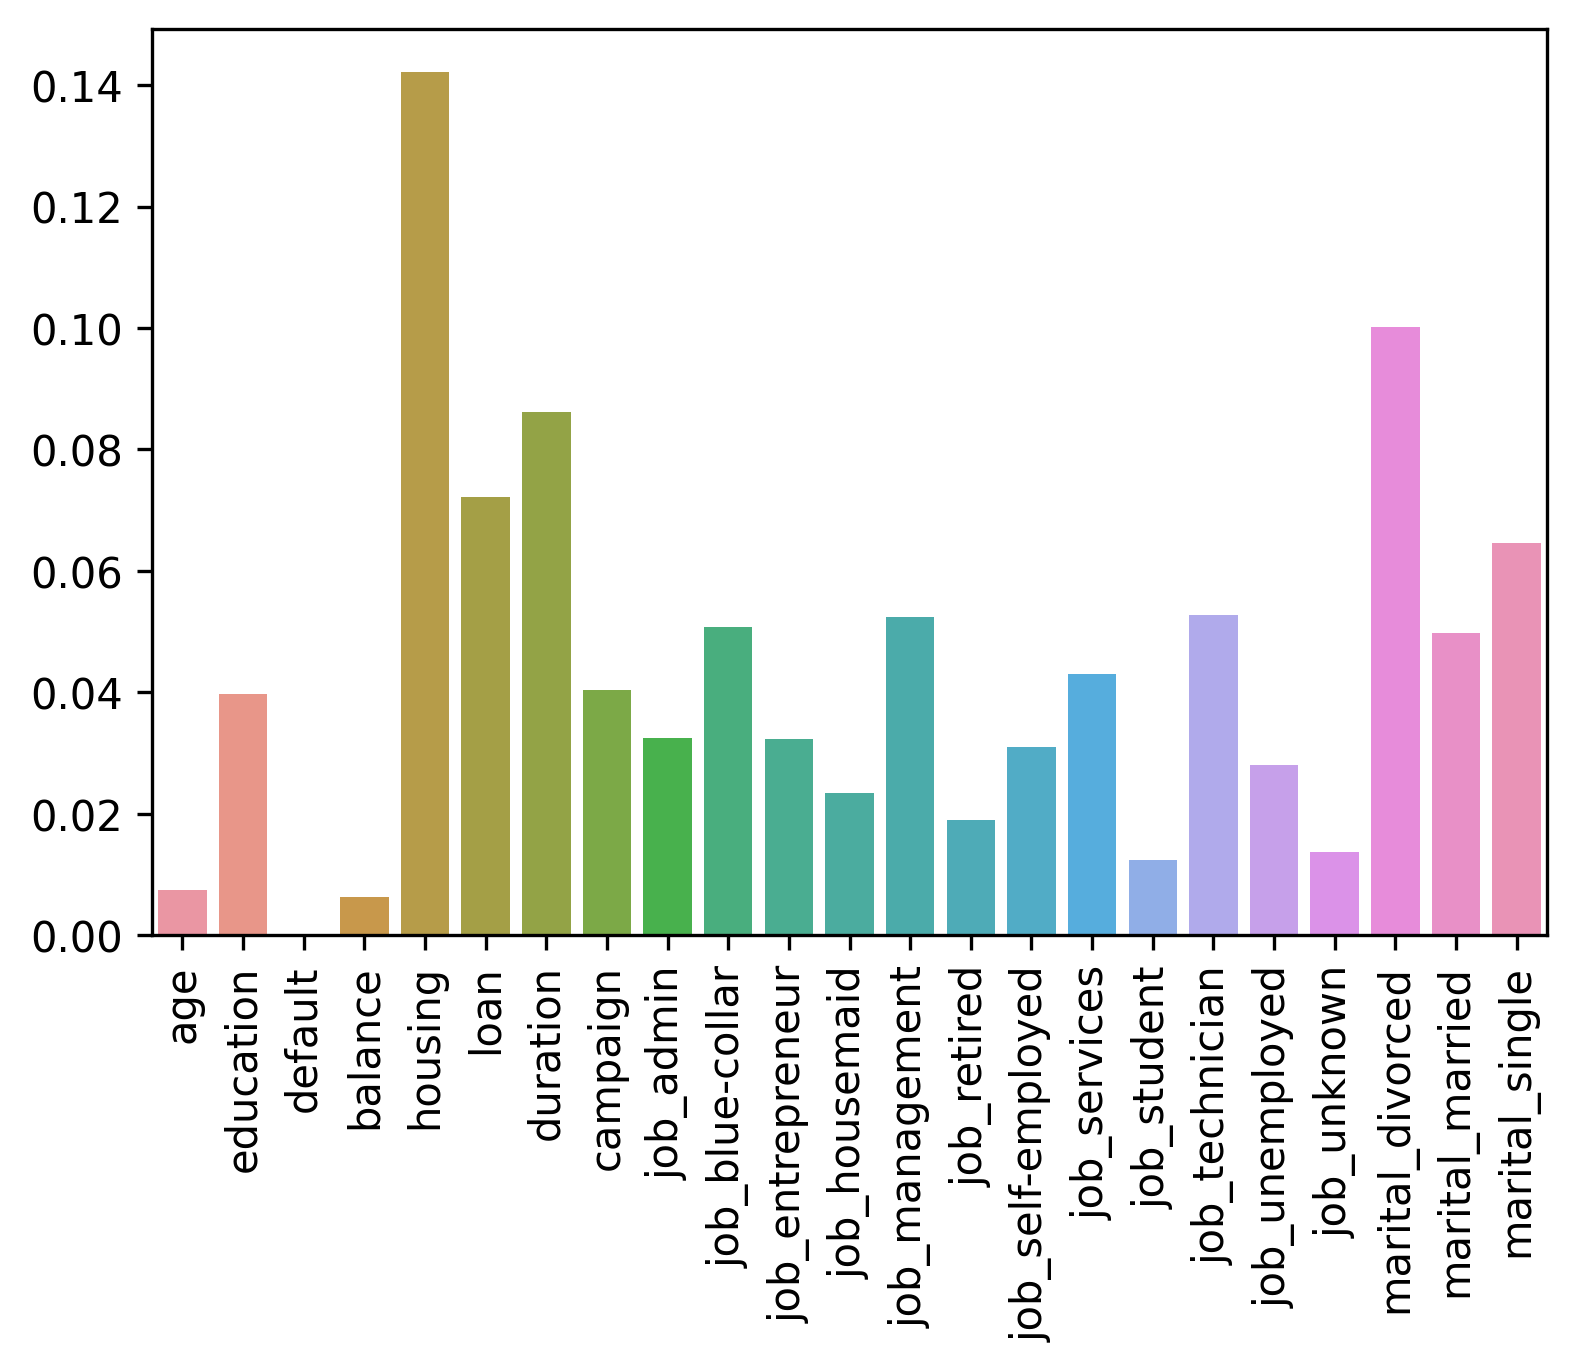

In [37]:
#@title
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt

plt.xticks(rotation=90)

sns.barplot(x = column_names, y = model.feature_importances_)

# based on the results from XGBboost machines, a person's 
##1. housing situation 
##2. marital staus 
##3. call duration 
##4. previous loan decision
#### are the most significant indicator to which group of customers will buy

In [ ]:
# feature importance can be intereprect as if a person's looking at prospects, which features they would pick first as "filters"

# for the question of which targets to pick, just look at the distribution of the "1" class

# ML for class-imbalance  : pick algorithms that does not assume distribution(non-parametric): knn, tree-based(Random forest(use average)/XGB boost(different weights for trees)(wins out most of time), ), 
# NN(works with assumes feature 2 exist becasue of feature 1 exist (sequential)),  Convulutional NN(need scaling)

# We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
# In the graphs below, the blue indicates the proportion of the customers who brought the product

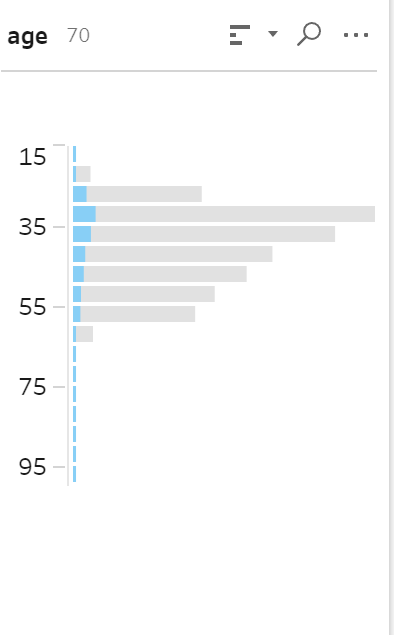

## Based on the distribution of age, we should prioritize people form 60 and above (on average more than 30% of those reached brought the product)

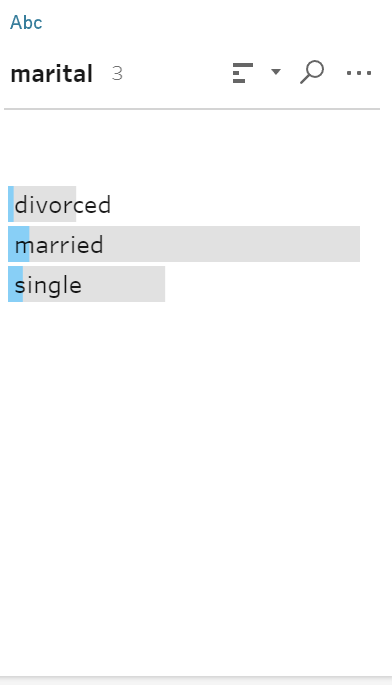

# based on marrital status, single and devorsed targets are more likly to buy vs married (8.5% vs 6%)


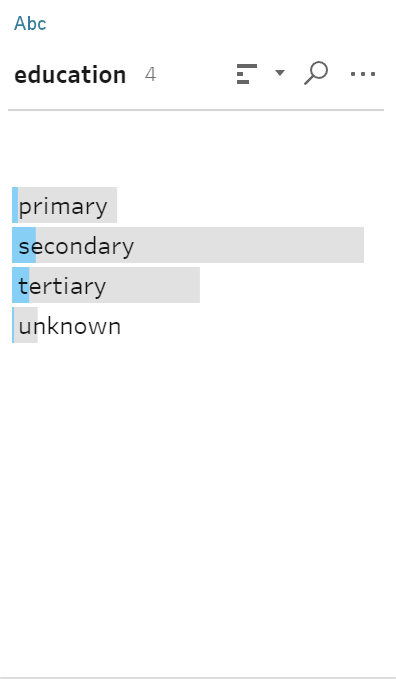

# the higher the education level, the more likly a person is going to buy the product(but by small margins)
## primary: 6%
## secondary: 7%
## tertiary: 9%

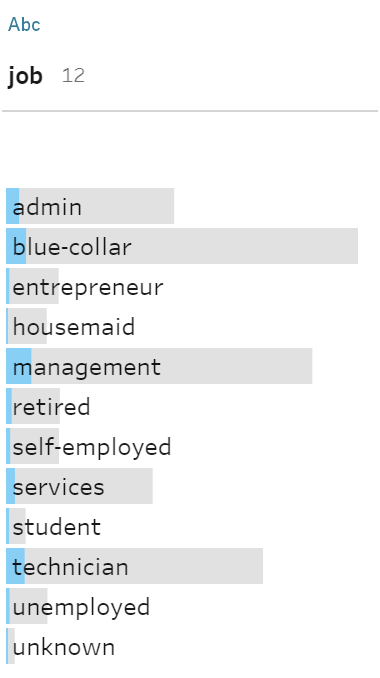

# based on career:
# those with higher averge yearly income has higher chance of buying the product